# Align images

The purpose of this notebook is to show how to perform image alignment (registration) with a feature-based approach with Orb (Oriented FAST and Rotated BRIEF). Image registration is currently used in various applications, like: image stitching, panorama creation, object tracking, medical image registration, and augmented reality.

The principle of feature-based registration involves the following steps:

- Feature Extraction: In this step features i.e. points, corners, edges or other descriptors are identified.

- Feature Matching: In this step, corresponding features are identified between the images. Best matches that represent the same underlying points or structures in the different images are detected.

- Transformation Estimation: Once the corresponding features are identified, the next step is to estimate the transformation that aligns the images.

- Transformation Application: The transofrmation is applied to all the pixels in the image.

- Refinement (Optional): Depending on the application and the quality of the initial alignment, further refinement steps may be performed to improve the accuracy of the registration.

In [1]:
# import the necessary packages
import numpy as np
import imutils
import matplotlib.pyplot as plt
import os
import cv2
from pathlib import Path

In [2]:
# Helper functions

def DrawMatches(im1, im2, kp1, kp2, matches, axis=1, margin=0, background=0, linewidth=2):
    '''Draw keypoints and matches.'''
    
    composite, v_offset, h_offset = BuildCompositeImage(im1, im2, axis, margin, background)

    # Draw all keypoints.
    for coord_a, coord_b in zip(kp1, kp2):
        composite = cv2.drawMarker(composite, (int(coord_a[0] + h_offset[0]), int(coord_a[1] + v_offset[0])), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=1)
        composite = cv2.drawMarker(composite, (int(coord_b[0] + h_offset[1]), int(coord_b[1] + v_offset[1])), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=1)
    
    # Draw matches, and highlight keypoints used in matches.
    for idx_a, idx_b in matches:
        composite = cv2.drawMarker(composite, (int(kp1[idx_a, 0] + h_offset[0]), int(kp1[idx_a, 1] + v_offset[0])), color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=1)
        composite = cv2.drawMarker(composite, (int(kp2[idx_b, 0] + h_offset[1]), int(kp2[idx_b, 1] + v_offset[1])), color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=1)
        composite = cv2.line(composite,
                             tuple([int(kp1[idx_a][0] + h_offset[0]),
                                   int(kp1[idx_a][1] + v_offset[0])]),
                             tuple([int(kp2[idx_b][0] + h_offset[1]),
                                   int(kp2[idx_b][1] + v_offset[1])]), color=(0, 0, 255), thickness=5)
    return composite


def ArrayFromCvKps(kps):
    '''Convenience function to convert OpenCV keypoints into a simple numpy array.'''
    return np.array([kp.pt for kp in kps])


def BuildCompositeImage(im1, im2, axis=1, margin=0, background=1):
    '''Convenience function to stack two images with different sizes.'''
    
    if background != 0 and background != 1:
        background = 1
    if axis != 0 and axis != 1:
        raise RuntimeError('Axis must be 0 (vertical) or 1 (horizontal')

    h1, w1, _ = im1.shape
    h2, w2, _ = im2.shape

    if axis == 1:
        composite = np.zeros((max(h1, h2), w1 + w2 + margin, 3), dtype=np.uint8) + 255 * background
        if h1 > h2:
            voff1, voff2 = 0, (h1 - h2) // 2
        else:
            voff1, voff2 = (h2 - h1) // 2, 0
        hoff1, hoff2 = 0, w1 + margin
    else:
        composite = np.zeros((h1 + h2 + margin, max(w1, w2), 3), dtype=np.uint8) + 255 * background
        if w1 > w2:
            hoff1, hoff2 = 0, (w1 - w2) // 2
        else:
            hoff1, hoff2 = (w2 - w1) // 2, 0
        voff1, voff2 = 0, h1 + margin
    composite[voff1:voff1 + h1, hoff1:hoff1 + w1, :] = im1
    composite[voff2:voff2 + h2, hoff2:hoff2 + w2, :] = im2

    return (composite, (voff1, voff2), (hoff1, hoff2))


def rotate(img, angle, rotPoint=None):
    ''' help function to rotate'''
    (height,width) = img.shape[:2]

    if rotPoint is None:
        rotPoint = (width//2, height//2)  # we rotate around the center

    rotMat = cv2.getRotationMatrix2D(rotPoint, angle, 1.0)
    dimensions = (width, height)

    return cv2.warpAffine(img, rotMat, dimensions)

In [3]:
def align_images(image, template, maxFeatures=500, keepPercent=0.2, debug=False):
    ''' Align image to template'''
    # convert both the input image and template to grayscale
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # use ORB to detect keypoints and extract (binary) local
    # invariant features
    orb = cv2.ORB_create(maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)
    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)
    
    # Convert keypoints and matches to something more human-readable.
    cur_kp_1 = ArrayFromCvKps(kpsA)
    cur_kp_2 = ArrayFromCvKps(kpsB)
    matches = np.array([[m.queryIdx, m.trainIdx] for m in matches])
    
    (H, inlier_mask) = cv2.findHomography(cur_kp_1[matches[:, 0]], cur_kp_2[matches[:, 1]], method=cv2.RANSAC)
    
    # check to see if we should visualize the matched keypoints
    if debug:
        #im_inliers = cv2.drawMatches((input_dict, cur_kp_1, cur_kp_2, matches_after_ransac))
        matches_after_ransac = np.array([match for match, is_inlier in zip(matches, inlier_mask) if is_inlier])
        im_inliers = DrawMatches(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cv2.cvtColor(template, cv2.COLOR_BGR2RGB), cur_kp_1, cur_kp_2, matches_after_ransac)
        fig = plt.figure(figsize=(12, 12))
        plt.title('Matches after RANSAC')
        plt.imshow(im_inliers)
        plt.axis('off')
        plt.show()
              
    # use the homography matrix to align the images
    (h, w) = template.shape[:2]
    aligned = cv2.warpPerspective(image, H, (w, h))
    # return the aligned image
    return aligned

In [4]:
# read the image on the disk
source_path = Path().absolute().parent
image1_path = os.path.join(source_path, 'Data', 'image1A.jpg')

In [5]:
img1 = cv2.imread(image1_path)
# apply a rotation and then try to transform it to be aligned with img1
rotated = rotate(img1, -45) 

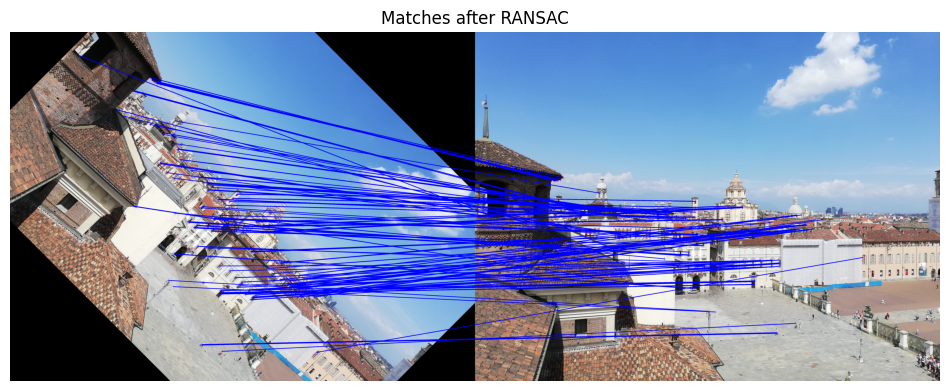

In [6]:
aligned_image = align_images(rotated, img1, maxFeatures=500, keepPercent=0.2, debug=True)

In [7]:
# In this figure we have the rotated image on the left and the original image on the right
# In blue matches between the two images

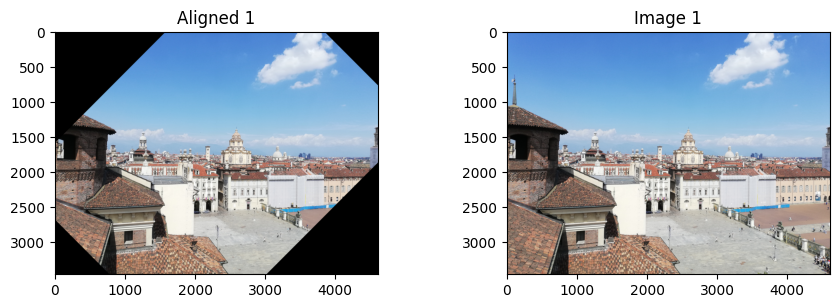

In [8]:
# Create a figure and axis objects
fig, axes = plt.subplots(1, 2, figsize=(10,10))
    
# Plot the aligned image on the left
axes[0].imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Aligned 1')

# Plot the original image on the right
axes[1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[1].set_title('Image 1')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)

In [9]:
# The image on the left has been aligned to original image (right) by using image registration